# fckg Demo: Best Picture from Ontology + API Enrichment

This notebook shows how to use the FilmClub ontology (`movieontology.ttl`) and the
reference dataset (`oscar_nominated_movies.ttl`) together. We will:

1. Load the RDF knowledge graph and query Best Picture nominations with TMDB/IMDB IDs.
2. Aggregate producer nominations to film-level features.
3. Enrich films via TMDB and OMDB APIs (cached to CSV for instant re-runs).
4. Engineer features from raw API data (genres, ratings, budgets, MPAA, etc.).
5. Explore feature relationships with enhanced EDA (9-panel visualization).
6. Perform feature significance analysis (correlations, Mann-Whitney U, chi-squared, mutual information).
7. Train a Best Picture model with expanded features (Logistic Regression + Random Forest).
8. Evaluate on the latest year's hold-out set.

In [76]:
# Imports
import pandas as pd
import numpy as np
import os
import time
import json
import re
import ast
import warnings
import requests
import matplotlib.pyplot as plt
import seaborn as sns

from rdflib import Graph, Namespace
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFECV, mutual_info_classif
from sklearn.metrics import roc_auc_score
from scipy.stats import linregress, mannwhitneyu, chi2_contingency

warnings.filterwarnings('ignore', category=FutureWarning)

%matplotlib inline
sns.set_style('whitegrid')

# Load .env for API keys
try:
    from dotenv import load_dotenv
    load_dotenv()
except Exception:
    print('dotenv not installed; skipping .env load')

TMDB_API_KEY = os.environ.get('TMDB_API_KEY', '')
OMDB_API_KEY = os.environ.get('OMDB_API_KEY', '')
print(f'TMDB API key: {"set" if TMDB_API_KEY else "MISSING"}')
print(f'OMDB API key: {"set" if OMDB_API_KEY else "MISSING"}')

# Load ontology + reference data
ONTO_PATH = 'movieontology.ttl'
DATA_PATH = 'oscar_nominated_movies.ttl'

g = Graph()
g.parse(ONTO_PATH, format='turtle')
g.parse(DATA_PATH, format='turtle')

MSH = Namespace('http://example.org/ontologies/MovieSHACL3#')

print(f'Triples loaded: {len(g):,}')

TMDB API key: set
OMDB API key: set
Triples loaded: 303,338


In [77]:
# 1) Query Best Picture nominations + nominee history + TMDB/IMDB IDs from RDF
query_bp = '''
PREFIX msh: <http://example.org/ontologies/MovieSHACL3#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?film ?filmTitle ?yearFilm ?winner ?nominee ?prevNoms ?prevWins ?tmdbVal ?imdbVal WHERE {
  ?nom a msh:Nomination ;
       msh:hasCategory ?cat ;
       msh:hasFilm ?film ;
       msh:yearFilm ?yearFilm ;
       msh:winner ?winner .
  ?cat rdfs:label "BEST PICTURE" .
  ?film msh:title ?filmTitle .
  OPTIONAL { ?nom msh:hasNominee ?nominee }
  OPTIONAL { ?nom msh:previousNominations ?prevNoms }
  OPTIONAL { ?nom msh:previousWins ?prevWins }
  OPTIONAL {
    ?film msh:hasIdentifier ?identTmdb .
    ?identTmdb msh:scheme msh:tmdb ;
               msh:value ?tmdbVal .
  }
  OPTIONAL {
    ?film msh:hasIdentifier ?identImdb .
    ?identImdb msh:scheme msh:imdb ;
               msh:value ?imdbVal .
  }
}
ORDER BY ?yearFilm ?filmTitle
'''

rows = []
for row in g.query(query_bp):
    rows.append({
        'film': str(row.filmTitle),
        'year_film': int(str(row.yearFilm)),
        'winner': str(row.winner).lower() == 'true',
        'nominee': str(row.nominee) if row.nominee else None,
        'previous_nominations': int(row.prevNoms) if row.prevNoms is not None else 0,
        'previous_wins': int(row.prevWins) if row.prevWins is not None else 0,
        'tmdb_id': str(row.tmdbVal) if row.tmdbVal else None,
        'imdb_id': str(row.imdbVal) if row.imdbVal else None,
    })

bp_df = pd.DataFrame(rows)
print(f'Best Picture rows: {len(bp_df)} (producer-level)')
print(f"Unique films: {bp_df['film'].nunique()}")
print(f"Films with tmdb_id: {bp_df.dropna(subset=['tmdb_id'])['film'].nunique()}")
print(f"Films with imdb_id: {bp_df.dropna(subset=['imdb_id'])['film'].nunique()}")

latest_year = bp_df['year_film'].max()
print(f'Latest film year in dataset: {latest_year}')

Best Picture rows: 877 (producer-level)
Unique films: 391
Films with tmdb_id: 391
Films with imdb_id: 391
Latest film year in dataset: 2025


In [78]:
# 2) Compute other_noms per film/year from all nominations, then aggregate to film-level
query_all = '''
PREFIX msh: <http://example.org/ontologies/MovieSHACL3#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?filmTitle ?yearFilm ?catLabel WHERE {
  ?nom a msh:Nomination ;
       msh:hasCategory ?cat ;
       msh:hasFilm ?film ;
       msh:yearFilm ?yearFilm .
  ?cat rdfs:label ?catLabel .
  ?film msh:title ?filmTitle .
}
'''

all_rows = []
for row in g.query(query_all):
    all_rows.append({
        'film': str(row.filmTitle),
        'year_film': int(str(row.yearFilm)),
        'category': str(row.catLabel),
    })

all_noms = pd.DataFrame(all_rows)
other_noms = (
    all_noms.groupby(['film', 'year_film'])['category']
    .nunique()
    .reset_index()
    .rename(columns={'category': 'other_noms'})
)

# --- Classify nominations into meaningful category groups ---
def classify_category(cat):
    cat_upper = cat.upper().strip()
    if cat_upper in ('ACTOR', 'ACTRESS', 'ACTOR IN A LEADING ROLE', 'ACTOR IN A SUPPORTING ROLE',
                     'ACTRESS IN A LEADING ROLE', 'ACTRESS IN A SUPPORTING ROLE'):
        return 'acting'
    if cat_upper.startswith('DIRECTING'):
        return 'directing'
    if cat_upper.startswith('WRITING'):
        return 'writing'
    if cat_upper.startswith('CINEMATOGRAPHY'):
        return 'cinematography'
    if cat_upper == 'FILM EDITING':
        return 'editing'
    if cat_upper.startswith('MUSIC'):
        return 'music'
    if any(cat_upper.startswith(t) for t in (
        'SOUND', 'VISUAL EFFECTS', 'SPECIAL VISUAL EFFECTS', 'SPECIAL EFFECTS',
        'COSTUME DESIGN', 'MAKEUP', 'ART DIRECTION', 'PRODUCTION DESIGN',
        'SPECIAL ACHIEVEMENT AWARD',
    )):
        return 'technical'
    return None  # other categories (shorts, docs, honorary, BP itself, etc.)

all_noms['category_group'] = all_noms['category'].apply(classify_category)

# Pivot to film-level category counts (only rows with a group assignment)
cat_noms = all_noms[all_noms['category_group'].notna()].copy()
cat_counts = (
    cat_noms.groupby(['film', 'year_film', 'category_group'])['category']
    .nunique()
    .reset_index()
    .rename(columns={'category': 'count'})
)
cat_pivot = cat_counts.pivot_table(
    index=['film', 'year_film'], columns='category_group', values='count', fill_value=0
).reset_index()

# Rename to final feature names
group_rename = {
    'acting': 'acting_noms',
    'directing': 'directing_nom',
    'writing': 'writing_noms',
    'cinematography': 'cinematography_nom',
    'editing': 'editing_nom',
    'technical': 'technical_noms',
    'music': 'music_noms',
}
cat_pivot = cat_pivot.rename(columns=group_rename)

# Ensure all columns exist (some films may have zero in a group)
for col in group_rename.values():
    if col not in cat_pivot.columns:
        cat_pivot[col] = 0

# Derived: above_line_noms = acting + directing + writing
cat_pivot['above_line_noms'] = (
    cat_pivot['acting_noms'] + cat_pivot['directing_nom'] + cat_pivot['writing_noms']
)

print(f"Category group features computed for {len(cat_pivot)} films")
print(f"\nCategory group distribution (BP nominees only — after merge):")
display(cat_pivot[list(group_rename.values()) + ['above_line_noms']].describe().round(2))

# Aggregate Best Picture producers to film-level
bp_agg = bp_df.groupby(['film', 'year_film']).agg(
    previous_nominations_sum=('previous_nominations', 'sum'),
    previous_nominations_max=('previous_nominations', 'max'),
    previous_nominations_avg=('previous_nominations', 'mean'),
    previous_wins_sum=('previous_wins', 'sum'),
    previous_wins_max=('previous_wins', 'max'),
    previous_wins_any=('previous_wins', lambda x: int((x > 0).any())),
    num_producers=('nominee', 'size'),
    winner=('winner', 'max'),
    tmdb_id=('tmdb_id', 'first'),
    imdb_id=('imdb_id', 'first'),
).reset_index()

bp_agg = bp_agg.merge(other_noms, on=['film', 'year_film'], how='left')
bp_agg = bp_agg.merge(cat_pivot, on=['film', 'year_film'], how='left')

# Fill NaN category counts with 0 (films with no noms in a group)
cat_feature_cols = list(group_rename.values()) + ['above_line_noms']
bp_agg[cat_feature_cols] = bp_agg[cat_feature_cols].fillna(0).astype(int)

print(f'\nFilm-level rows: {len(bp_agg)}')
print(f"Films with tmdb_id: {bp_agg['tmdb_id'].notna().sum()}")
print(f"Films with imdb_id: {bp_agg['imdb_id'].notna().sum()}")
print(f"\nNew category features sample:")
display(bp_agg[['film', 'year_film', 'other_noms'] + cat_feature_cols].head(10))

Category group features computed for 3162 films

Category group distribution (BP nominees only — after merge):


category_group,acting_noms,directing_nom,writing_noms,cinematography_nom,editing_nom,technical_noms,music_noms,above_line_noms
count,3162.00,3162.00,3162.00,3162.0,3162.00,3162.00,3162.00,3162.00
mean,0.57,0.15,0.33,0.2,0.15,0.69,0.41,1.05
std,0.83,0.36,0.48,0.4,0.35,0.97,0.59,1.31
min,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.0,0.00,0.00,0.00,1.00
75%,1.00,0.00,1.00,0.0,0.00,1.00,1.00,2.00
max,4.00,1.00,2.00,1.0,1.00,6.00,3.00,6.00



Film-level rows: 391
Films with tmdb_id: 391
Films with imdb_id: 391

New category features sample:


,film,year_film,other_noms,acting_noms,directing_nom,writing_noms,cinematography_nom,editing_nom,technical_noms,music_noms,above_line_noms
0,12 Years a Slave,2013,9,3,1,1,0,1,2,0,5
1,127 Hours,2010,6,1,0,1,0,1,0,2,2
2,1917,2019,10,0,1,1,1,0,5,1,2
3,A Beautiful Mind,2001,8,2,1,1,0,1,1,1,4
4,A Clockwork Orange,1971,4,0,1,1,0,1,0,0,2
5,A Complete Unknown,2024,8,3,1,1,0,0,2,0,5
6,A Few Good Men,1992,4,1,0,0,0,1,1,0,1
7,A Man for All Seasons,1966,8,3,1,1,1,0,1,0,5
8,A Passage to India,1984,11,2,1,1,1,1,3,1,4
9,A Room with a View,1986,8,2,1,1,1,0,2,0,4


In [79]:
# 3) API Enrichment with caching (TMDB + OMDB)
CACHE_PATH = 'best_picture_enrichment_cache.csv'

if os.path.exists(CACHE_PATH):
    enrichment = pd.read_csv(CACHE_PATH)
    enrichment['tmdb_id'] = enrichment['tmdb_id'].astype(str)
    print(f'Loaded enrichment cache: {len(enrichment)} rows from {CACHE_PATH}')
else:
    print(f'Cache not found. Fetching from TMDB + OMDB APIs for {len(bp_agg)} films...')
    records = []

    for i, (_, row) in enumerate(bp_agg.iterrows()):
        tmdb_id = row['tmdb_id']
        imdb_id = row['imdb_id']
        rec = {'tmdb_id': tmdb_id, 'imdb_id': imdb_id, 'film': row['film']}

        # --- TMDB ---
        if tmdb_id and TMDB_API_KEY:
            try:
                resp = requests.get(
                    f'https://api.themoviedb.org/3/movie/{tmdb_id}',
                    params={'api_key': TMDB_API_KEY},
                    timeout=10
                )
                if resp.status_code == 200:
                    d = resp.json()
                    rec['tmdb_budget'] = d.get('budget')
                    rec['tmdb_revenue'] = d.get('revenue')
                    rec['tmdb_runtime'] = d.get('runtime')
                    rec['tmdb_vote_average'] = d.get('vote_average')
                    rec['tmdb_vote_count'] = d.get('vote_count')
                    rec['tmdb_popularity'] = d.get('popularity')
                    rec['tmdb_genres'] = json.dumps([g_item['name'] for g_item in d.get('genres', [])])
                    rec['tmdb_original_language'] = d.get('original_language')
                    rec['tmdb_release_date'] = d.get('release_date')
                    rec['tmdb_production_companies'] = json.dumps(
                        [c['name'] for c in d.get('production_companies', [])]
                    )
                    rec['tmdb_tagline'] = d.get('tagline', '')
                time.sleep(0.25)
            except Exception as e:
                print(f'  TMDB error for {row["film"]}: {e}')

        # --- OMDB ---
        if imdb_id and OMDB_API_KEY:
            try:
                resp = requests.get(
                    'http://www.omdbapi.com/',
                    params={'i': imdb_id, 'apikey': OMDB_API_KEY},
                    timeout=10
                )
                if resp.status_code == 200:
                    d = resp.json()
                    if d.get('Response') == 'True':
                        rec['omdb_imdb_rating'] = d.get('imdbRating')
                        rec['omdb_rated'] = d.get('Rated')
                        rec['omdb_awards'] = d.get('Awards')
                        rec['omdb_country'] = d.get('Country')
                        rec['omdb_ratings'] = json.dumps(d.get('Ratings', []))
                time.sleep(0.25)
            except Exception as e:
                print(f'  OMDB error for {row["film"]}: {e}')

        records.append(rec)

        if (i + 1) % 50 == 0:
            print(f'  Progress: {i + 1}/{len(bp_agg)} films fetched')

    enrichment = pd.DataFrame(records)
    enrichment.to_csv(CACHE_PATH, index=False)
    print(f'\nSaved enrichment cache: {len(enrichment)} rows to {CACHE_PATH}')

print(f'\nEnrichment columns: {list(enrichment.columns)}')
print(f"TMDB data available: {enrichment['tmdb_budget'].notna().sum()}/{len(enrichment)}")
print(f"OMDB data available: {enrichment['omdb_imdb_rating'].notna().sum()}/{len(enrichment)}")

Loaded enrichment cache: 391 rows from best_picture_enrichment_cache.csv

Enrichment columns: ['tmdb_id', 'imdb_id', 'film', 'tmdb_budget', 'tmdb_revenue', 'tmdb_runtime', 'tmdb_vote_average', 'tmdb_vote_count', 'tmdb_popularity', 'tmdb_genres', 'tmdb_original_language', 'tmdb_release_date', 'tmdb_production_companies', 'tmdb_tagline', 'omdb_imdb_rating', 'omdb_rated', 'omdb_awards', 'omdb_country', 'omdb_ratings']
TMDB data available: 391/391
OMDB data available: 391/391


In [80]:
# 4) Feature Engineering — parse raw API data into model-ready features

# Merge enrichment into bp_agg
bp_agg['tmdb_id'] = bp_agg['tmdb_id'].astype(str).str.replace(r'\.0$', '', regex=True)
enrichment['tmdb_id'] = enrichment['tmdb_id'].astype(str).str.replace(r'\.0$', '', regex=True)

enrich_cols = [c for c in enrichment.columns if c not in ['film', 'imdb_id']]
bp_agg = bp_agg.merge(enrichment[enrich_cols], on='tmdb_id', how='left')

# --- TMDB numeric features ---
bp_agg['budget'] = pd.to_numeric(bp_agg['tmdb_budget'], errors='coerce')
bp_agg['revenue'] = pd.to_numeric(bp_agg['tmdb_revenue'], errors='coerce')
bp_agg['runtime'] = pd.to_numeric(bp_agg['tmdb_runtime'], errors='coerce')
bp_agg['vote_average'] = pd.to_numeric(bp_agg['tmdb_vote_average'], errors='coerce')
bp_agg['vote_count'] = pd.to_numeric(bp_agg['tmdb_vote_count'], errors='coerce')
bp_agg['popularity'] = pd.to_numeric(bp_agg['tmdb_popularity'], errors='coerce')
bp_agg['english_language'] = (bp_agg['tmdb_original_language'] == 'en').astype(int)

# --- Derived features ---
bp_agg['log_budget'] = np.log1p(bp_agg['budget'])
bp_agg['log_revenue'] = np.log1p(bp_agg['revenue'])
bp_agg['budget_revenue_ratio'] = np.where(
    bp_agg['budget'] > 0,
    bp_agg['revenue'] / bp_agg['budget'],
    np.nan
)

# Release month
def parse_release_month(d):
    try:
        return int(str(d).split('-')[1])
    except Exception:
        return np.nan

bp_agg['release_month'] = bp_agg['tmdb_release_date'].apply(parse_release_month)

# Tagline
bp_agg['has_tagline'] = bp_agg['tmdb_tagline'].apply(
    lambda x: 1 if isinstance(x, str) and len(x.strip()) > 0 else 0
)

# --- Genre flags ---
def safe_parse_json(x):
    if pd.isna(x):
        return []
    try:
        return json.loads(x)
    except Exception:
        try:
            return ast.literal_eval(x)
        except Exception:
            return []

bp_agg['_genres_list'] = bp_agg['tmdb_genres'].apply(safe_parse_json)
bp_agg['num_genres'] = bp_agg['_genres_list'].apply(len)

all_genres = sorted(set(g for gl in bp_agg['_genres_list'] for g in gl))
for genre in all_genres:
    col_name = f'genre_{genre.lower().replace(" ", "_").replace("-", "_")}'
    bp_agg[col_name] = bp_agg['_genres_list'].apply(lambda gl, g=genre: int(g in gl))

print(f'Genre flags created: {len(all_genres)} genres — {all_genres}')

# --- Production company prestige ---
bp_agg['_companies_list'] = bp_agg['tmdb_production_companies'].apply(safe_parse_json)

# Find companies appearing on 3+ BP winners
winner_companies = bp_agg[bp_agg['winner'] == True]['_companies_list'].explode()
prestige_companies = set(winner_companies.value_counts()[winner_companies.value_counts() >= 3].index)
bp_agg['has_prestige_company'] = bp_agg['_companies_list'].apply(
    lambda cl: int(any(c in prestige_companies for c in cl))
)
bp_agg['num_production_companies'] = bp_agg['_companies_list'].apply(len)

print(f'Prestige companies (3+ BP wins): {len(prestige_companies)}')
for pc in sorted(prestige_companies):
    print(f'  - {pc}')

# --- OMDB ratings ---
def parse_float(x):
    try:
        return float(str(x).replace('/10', '').replace('%', '').replace('/100', '').strip())
    except Exception:
        return np.nan

bp_agg['imdb_rating'] = bp_agg['omdb_imdb_rating'].apply(parse_float)

def parse_omdb_ratings(x):
    ratings = safe_parse_json(x)
    rt, mc = np.nan, np.nan
    for r in ratings:
        source = r.get('Source', '')
        val = r.get('Value', '')
        if 'Rotten Tomatoes' in source:
            rt = parse_float(val)
        elif 'Metacritic' in source:
            mc = parse_float(val)
    return rt, mc

rt_mc = bp_agg['omdb_ratings'].apply(parse_omdb_ratings)
bp_agg['rotten_tomatoes_pct'] = rt_mc.apply(lambda x: x[0])
bp_agg['metacritic_score'] = rt_mc.apply(lambda x: x[1])

# --- MPAA rating dummies ---
mpaa_map = {'R': 'rated_R', 'PG-13': 'rated_PG13', 'PG': 'rated_PG', 'G': 'rated_G'}
for mpaa, col in mpaa_map.items():
    bp_agg[col] = (bp_agg['omdb_rated'] == mpaa).astype(int)

# --- Awards parsing (EDA only — potential leakage) ---
def parse_awards(x):
    wins, noms = 0, 0
    if not isinstance(x, str) or x == 'N/A':
        return wins, noms
    # Pattern: "Won 3 Oscars. 5 wins & 10 nominations total."
    win_match = re.findall(r'(\d+)\s+win', x, re.IGNORECASE)
    nom_match = re.findall(r'(\d+)\s+nomination', x, re.IGNORECASE)
    oscar_win = re.findall(r'Won\s+(\d+)\s+Oscar', x, re.IGNORECASE)
    wins = sum(int(w) for w in win_match) + sum(int(w) for w in oscar_win)
    noms = sum(int(n) for n in nom_match)
    return wins, noms

awards_parsed = bp_agg['omdb_awards'].apply(parse_awards)
bp_agg['awards_wins'] = awards_parsed.apply(lambda x: x[0])
bp_agg['awards_nominations'] = awards_parsed.apply(lambda x: x[1])

# Clean up temp columns
bp_agg.drop(columns=['_genres_list', '_companies_list'], inplace=True)

# Summary
feature_cols = [c for c in bp_agg.columns if c not in [
    'film', 'year_film', 'winner', 'tmdb_id', 'imdb_id',
    'tmdb_budget', 'tmdb_revenue', 'tmdb_runtime', 'tmdb_vote_average',
    'tmdb_vote_count', 'tmdb_popularity', 'tmdb_genres', 'tmdb_original_language',
    'tmdb_release_date', 'tmdb_production_companies', 'tmdb_tagline',
    'omdb_imdb_rating', 'omdb_rated', 'omdb_awards', 'omdb_country', 'omdb_ratings'
]]
print(f'\nTotal engineered features: {len(feature_cols)}')
print(f'Dataset shape: {bp_agg.shape}')
print(f'\nFeature availability:')
for f in feature_cols:
    avail = bp_agg[f].notna().sum()
    print(f'  {f:35s}: {avail}/{len(bp_agg)}')

Genre flags created: 17 genres — ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'Thriller', 'War', 'Western']
Prestige companies (3+ BP wins): 9
  - 20th Century Fox
  - DreamWorks Pictures
  - Miramax
  - Paramount Pictures
  - Plan B Entertainment
  - The Saul Zaentz Company
  - United Artists
  - Universal Pictures
  - Warner Bros. Pictures

Total engineered features: 57
Dataset shape: (391, 78)

Feature availability:
  previous_nominations_sum           : 391/391
  previous_nominations_max           : 391/391
  previous_nominations_avg           : 391/391
  previous_wins_sum                  : 391/391
  previous_wins_max                  : 391/391
  previous_wins_any                  : 391/391
  num_producers                      : 391/391
  other_noms                         : 391/391
  acting_noms                        : 391/391
  cinematography_nom                 : 391

## Exploratory Data Analysis - Best Picture

Before building the model, let's explore how API-enriched features relate to winning Best Picture.
We examine ratings (TMDB, IMDB, Rotten Tomatoes), budgets, genres, MPAA ratings, and more.

BEST PICTURE - EXPLORATORY DATA ANALYSIS

Dataset: 391 films with core features
  Winners: 63 (16.1%)
  Nominees: 328 (83.9%)


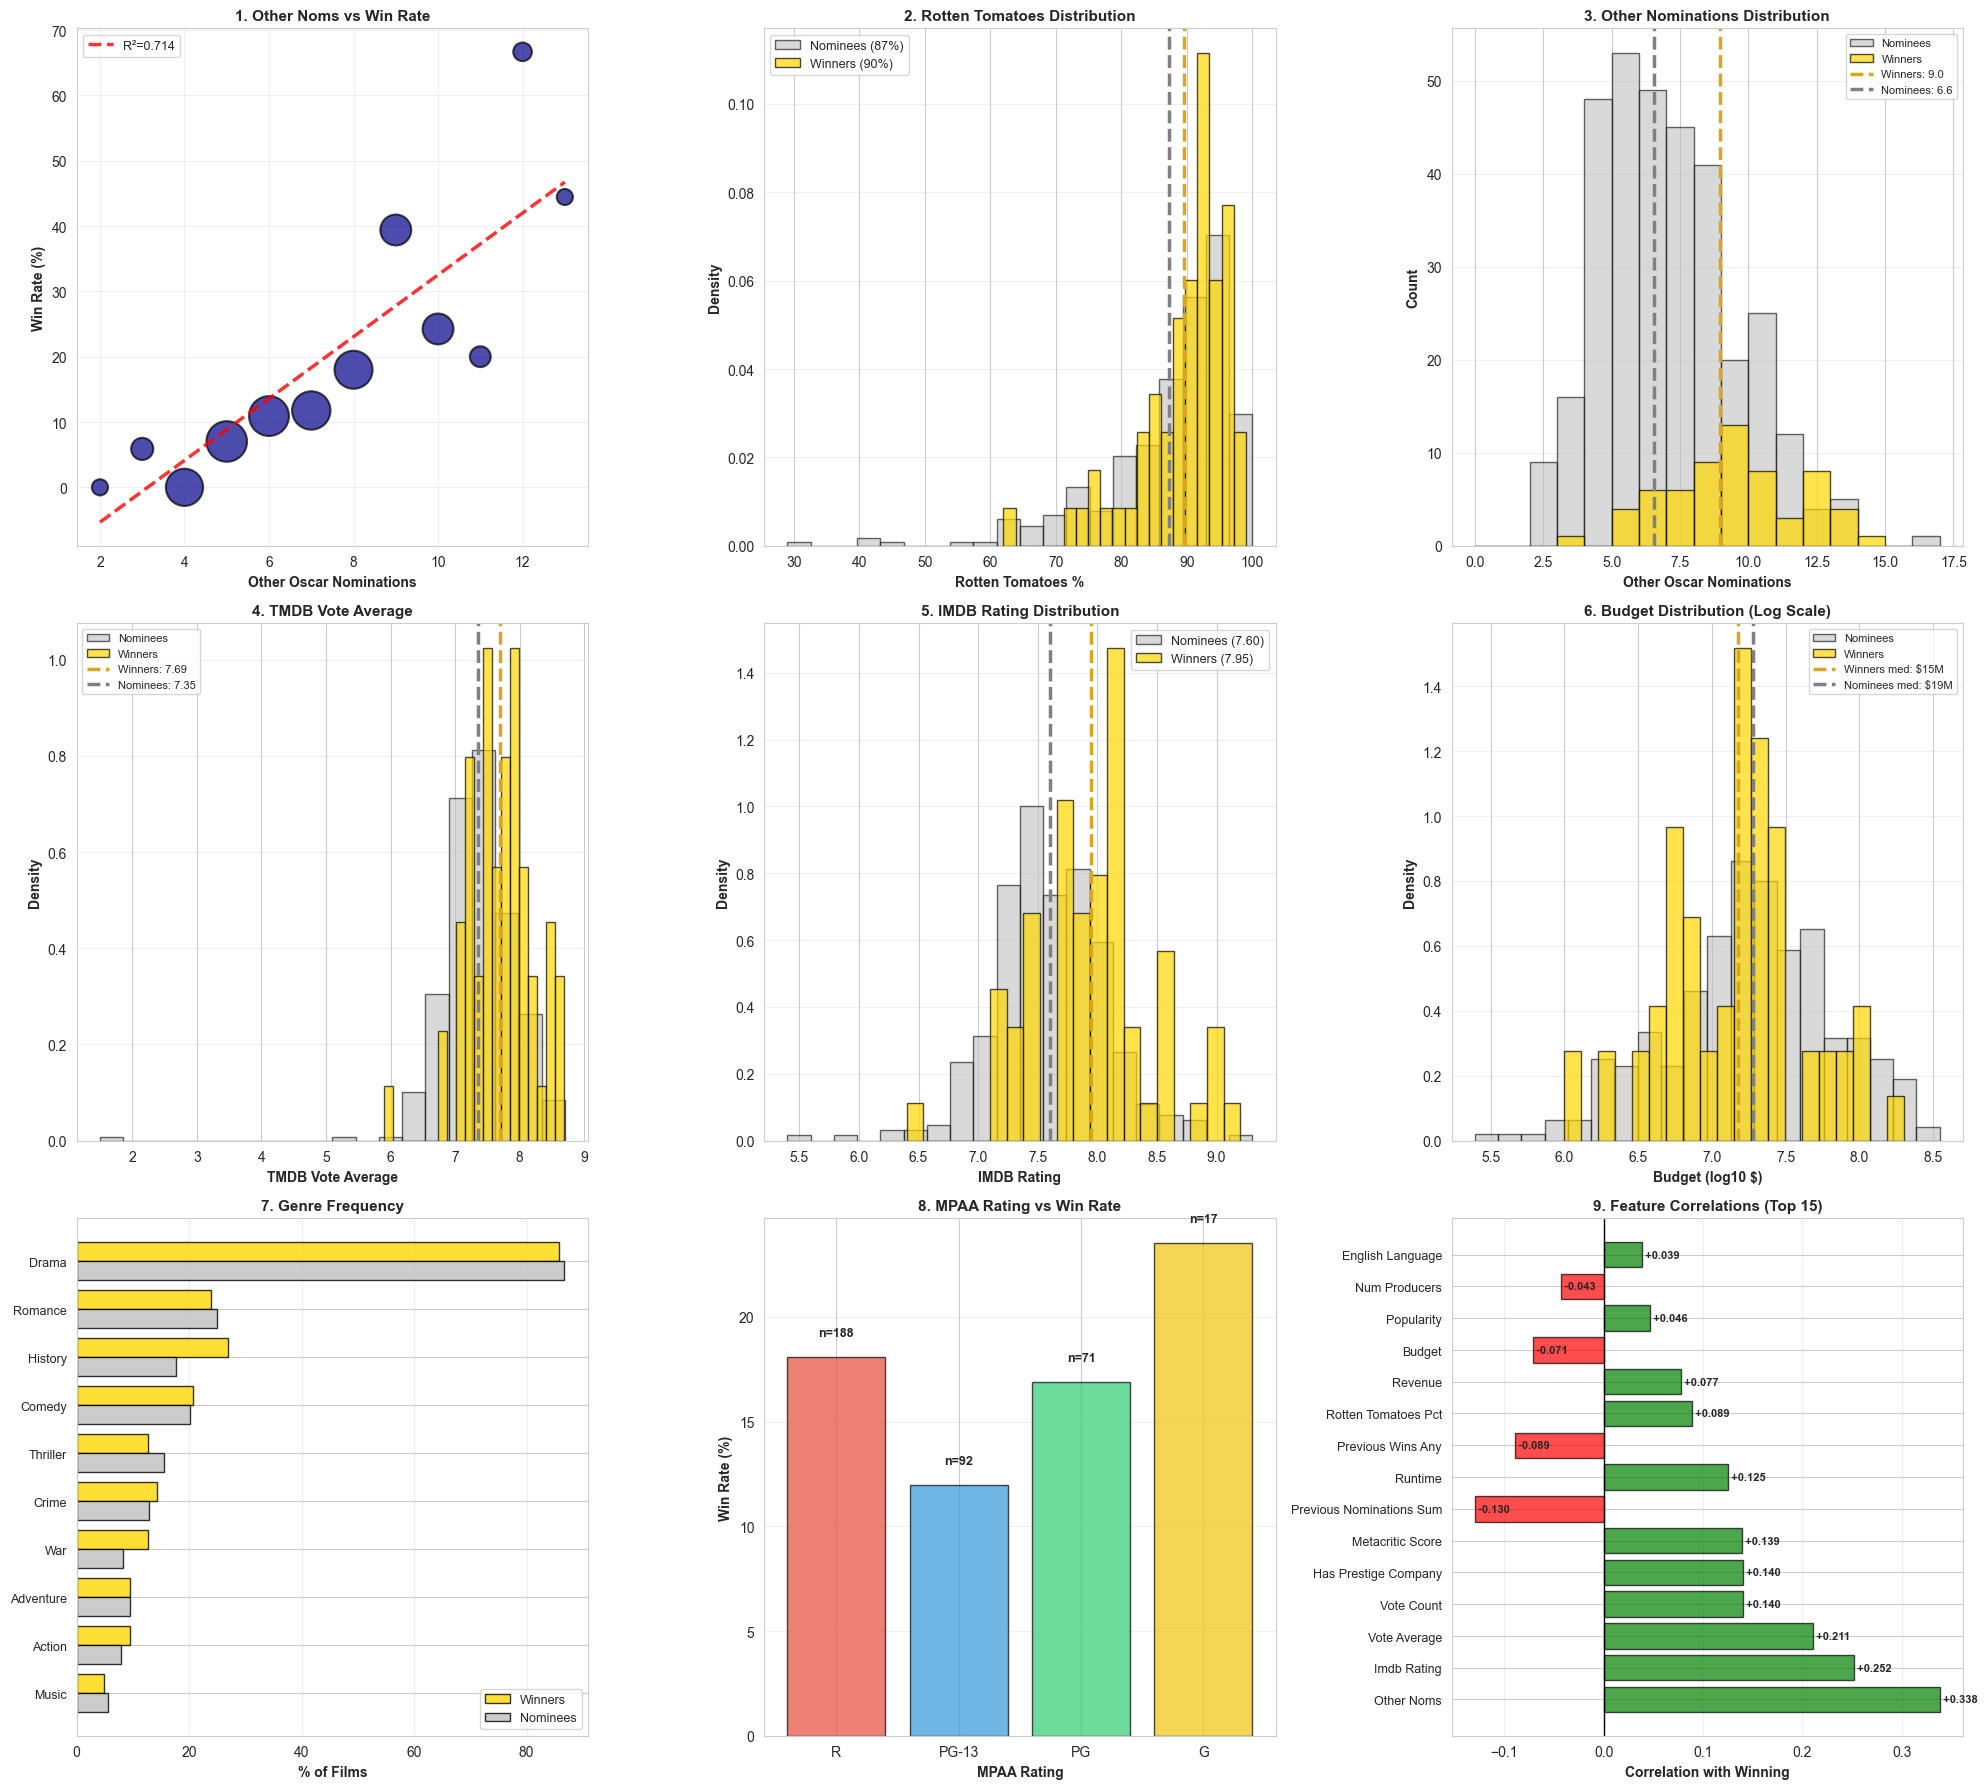


KEY FINDINGS

1. Other Nominations:   r=+0.338  |  Winners avg: 9.0  |  Nominees avg: 6.6
2. TMDB Vote Average:   r=+0.211  |  Winners avg: 7.69  |  Nominees avg: 7.35
3. IMDB Rating:         r=+0.252  |  Winners avg: 7.95  |  Nominees avg: 7.60
4. Rotten Tomatoes:     r=+0.089  |  Winners avg: 90%  |  Nominees avg: 87%


In [81]:
# EDA - Best Picture (9-panel 3x3)
bp_clean = bp_agg.dropna(subset=['vote_average', 'budget', 'runtime']).copy()
winners = bp_clean[bp_clean['winner'] == True]
nominees = bp_clean[bp_clean['winner'] == False]

print("=" * 100)
print("BEST PICTURE - EXPLORATORY DATA ANALYSIS")
print("=" * 100)
print(f"\nDataset: {len(bp_clean)} films with core features")
print(f"  Winners: {len(winners)} ({bp_clean['winner'].mean()*100:.1f}%)")
print(f"  Nominees: {len(nominees)} ({(~bp_clean['winner']).mean()*100:.1f}%)")

fig, axes = plt.subplots(3, 3, figsize=(20, 18))

# 1. Other Nominations vs Win Rate
ax = axes[0, 0]
wr_other = bp_clean.groupby('other_noms')['winner'].agg(['sum', 'count', 'mean']).reset_index()
wr_other.columns = ['other_noms', 'wins', 'count', 'win_rate']
wr_other_filt = wr_other[wr_other['count'] >= 3]
ax.scatter(wr_other_filt['other_noms'], wr_other_filt['win_rate'] * 100,
           s=wr_other_filt['count'] * 15, alpha=0.7, color='darkblue', edgecolors='black', linewidth=1.5)
if len(wr_other_filt) > 1:
    slope, intercept, r_value, *_ = linregress(wr_other_filt['other_noms'], wr_other_filt['win_rate'] * 100)
    x_t = np.linspace(wr_other_filt['other_noms'].min(), wr_other_filt['other_noms'].max(), 100)
    ax.plot(x_t, slope * x_t + intercept, 'r--', linewidth=2.5, alpha=0.8, label=f'R\u00b2={r_value**2:.3f}')
    ax.legend(fontsize=9)
ax.set_xlabel("Other Oscar Nominations", fontsize=10, fontweight='bold')
ax.set_ylabel('Win Rate (%)', fontsize=10, fontweight='bold')
ax.set_title("1. Other Noms vs Win Rate", fontsize=11, fontweight='bold')
ax.grid(alpha=0.3)

# 2. Rotten Tomatoes Distribution
ax = axes[0, 1]
rt_winners = winners['rotten_tomatoes_pct'].dropna()
rt_nominees = nominees['rotten_tomatoes_pct'].dropna()
if len(rt_winners) > 0 and len(rt_nominees) > 0:
    ax.hist(rt_nominees, bins=20, alpha=0.6, color='silver', label=f'Nominees ({rt_nominees.mean():.0f}%)', edgecolor='black', density=True)
    ax.hist(rt_winners, bins=20, alpha=0.7, color='gold', label=f'Winners ({rt_winners.mean():.0f}%)', edgecolor='black', density=True)
    ax.axvline(rt_winners.mean(), color='goldenrod', linestyle='--', linewidth=2.5)
    ax.axvline(rt_nominees.mean(), color='gray', linestyle='--', linewidth=2.5)
    ax.legend(fontsize=9)
ax.set_xlabel('Rotten Tomatoes %', fontsize=10, fontweight='bold')
ax.set_ylabel('Density', fontsize=10, fontweight='bold')
ax.set_title('2. Rotten Tomatoes Distribution', fontsize=11, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# 3. Other Nominations Distribution
ax = axes[0, 2]
max_on = int(bp_clean['other_noms'].max()) + 1
bins = range(0, max_on + 1)
ax.hist(nominees['other_noms'], bins=bins, alpha=0.6, color='silver', label='Nominees', edgecolor='black')
ax.hist(winners['other_noms'], bins=bins, alpha=0.7, color='gold', label='Winners', edgecolor='black')
ax.axvline(winners['other_noms'].mean(), color='goldenrod', linestyle='--', linewidth=2.5,
           label=f"Winners: {winners['other_noms'].mean():.1f}")
ax.axvline(nominees['other_noms'].mean(), color='gray', linestyle='--', linewidth=2.5,
           label=f"Nominees: {nominees['other_noms'].mean():.1f}")
ax.set_xlabel('Other Oscar Nominations', fontsize=10, fontweight='bold')
ax.set_ylabel('Count', fontsize=10, fontweight='bold')
ax.set_title('3. Other Nominations Distribution', fontsize=11, fontweight='bold')
ax.legend(fontsize=8)
ax.grid(axis='y', alpha=0.3)

# 4. TMDB Vote Average Distribution
ax = axes[1, 0]
ax.hist(nominees['vote_average'].dropna(), bins=20, alpha=0.6, color='silver', label='Nominees', edgecolor='black', density=True)
ax.hist(winners['vote_average'].dropna(), bins=20, alpha=0.7, color='gold', label='Winners', edgecolor='black', density=True)
ax.axvline(winners['vote_average'].mean(), color='goldenrod', linestyle='--', linewidth=2.5,
           label=f"Winners: {winners['vote_average'].mean():.2f}")
ax.axvline(nominees['vote_average'].mean(), color='gray', linestyle='--', linewidth=2.5,
           label=f"Nominees: {nominees['vote_average'].mean():.2f}")
ax.set_xlabel('TMDB Vote Average', fontsize=10, fontweight='bold')
ax.set_ylabel('Density', fontsize=10, fontweight='bold')
ax.set_title('4. TMDB Vote Average', fontsize=11, fontweight='bold')
ax.legend(fontsize=8)
ax.grid(axis='y', alpha=0.3)

# 5. IMDB Rating Distribution
ax = axes[1, 1]
imdb_w = winners['imdb_rating'].dropna()
imdb_n = nominees['imdb_rating'].dropna()
if len(imdb_w) > 0 and len(imdb_n) > 0:
    ax.hist(imdb_n, bins=20, alpha=0.6, color='silver', label=f'Nominees ({imdb_n.mean():.2f})', edgecolor='black', density=True)
    ax.hist(imdb_w, bins=20, alpha=0.7, color='gold', label=f'Winners ({imdb_w.mean():.2f})', edgecolor='black', density=True)
    ax.axvline(imdb_w.mean(), color='goldenrod', linestyle='--', linewidth=2.5)
    ax.axvline(imdb_n.mean(), color='gray', linestyle='--', linewidth=2.5)
    ax.legend(fontsize=9)
ax.set_xlabel('IMDB Rating', fontsize=10, fontweight='bold')
ax.set_ylabel('Density', fontsize=10, fontweight='bold')
ax.set_title('5. IMDB Rating Distribution', fontsize=11, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# 6. Budget Distribution (log scale)
ax = axes[1, 2]
budget_w = winners['budget'][winners['budget'] > 0]
budget_n = nominees['budget'][nominees['budget'] > 0]
if len(budget_w) > 0 and len(budget_n) > 0:
    ax.hist(np.log10(budget_n), bins=20, alpha=0.6, color='silver', label='Nominees', edgecolor='black', density=True)
    ax.hist(np.log10(budget_w), bins=20, alpha=0.7, color='gold', label='Winners', edgecolor='black', density=True)
    ax.axvline(np.log10(budget_w.median()), color='goldenrod', linestyle='--', linewidth=2.5,
               label=f'Winners med: ${budget_w.median()/1e6:.0f}M')
    ax.axvline(np.log10(budget_n.median()), color='gray', linestyle='--', linewidth=2.5,
               label=f'Nominees med: ${budget_n.median()/1e6:.0f}M')
    ax.legend(fontsize=8)
ax.set_xlabel('Budget (log10 $)', fontsize=10, fontweight='bold')
ax.set_ylabel('Density', fontsize=10, fontweight='bold')
ax.set_title('6. Budget Distribution (Log Scale)', fontsize=11, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# 7. Genre frequency (grouped bar)
ax = axes[2, 0]
genre_cols = [c for c in bp_clean.columns if c.startswith('genre_')]
if genre_cols:
    genre_data = []
    for gc in genre_cols:
        gname = gc.replace('genre_', '').replace('_', ' ').title()
        w_pct = winners[gc].mean() * 100 if gc in winners.columns else 0
        n_pct = nominees[gc].mean() * 100 if gc in nominees.columns else 0
        genre_data.append((gname, w_pct, n_pct))
    genre_data.sort(key=lambda x: x[1] + x[2], reverse=True)
    genre_data = genre_data[:10]  # Top 10 genres
    gnames, w_pcts, n_pcts = zip(*genre_data)
    x_pos = np.arange(len(gnames))
    ax.barh(x_pos - 0.2, w_pcts, 0.4, color='gold', alpha=0.8, label='Winners', edgecolor='black')
    ax.barh(x_pos + 0.2, n_pcts, 0.4, color='silver', alpha=0.8, label='Nominees', edgecolor='black')
    ax.set_yticks(x_pos)
    ax.set_yticklabels(gnames, fontsize=9)
    ax.set_xlabel('% of Films', fontsize=10, fontweight='bold')
    ax.set_title('7. Genre Frequency', fontsize=11, fontweight='bold')
    ax.legend(fontsize=9)
    ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# 8. MPAA Rating vs Win Rate
ax = axes[2, 1]
mpaa_cols = ['rated_R', 'rated_PG13', 'rated_PG', 'rated_G']
mpaa_labels = ['R', 'PG-13', 'PG', 'G']
mpaa_available = [c for c in mpaa_cols if c in bp_clean.columns]
if mpaa_available:
    mpaa_data = []
    for col, label in zip(mpaa_cols, mpaa_labels):
        if col in bp_clean.columns:
            subset = bp_clean[bp_clean[col] == 1]
            if len(subset) > 0:
                mpaa_data.append((label, subset['winner'].mean() * 100, len(subset)))
    if mpaa_data:
        mlabels, mrates, mcounts = zip(*mpaa_data)
        colors_mpaa = ['#e74c3c', '#3498db', '#2ecc71', '#f1c40f']
        bars = ax.bar(mlabels, mrates, color=colors_mpaa[:len(mlabels)], alpha=0.7, edgecolor='black')
        for bar, cnt in zip(bars, mcounts):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'n={cnt}', ha='center', fontsize=9, fontweight='bold')
ax.set_xlabel('MPAA Rating', fontsize=10, fontweight='bold')
ax.set_ylabel('Win Rate (%)', fontsize=10, fontweight='bold')
ax.set_title('8. MPAA Rating vs Win Rate', fontsize=11, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# 9. Feature Correlations (top 15)
ax = axes[2, 2]
corr_candidates = [
    'other_noms', 'vote_average', 'imdb_rating', 'rotten_tomatoes_pct', 'metacritic_score',
    'previous_nominations_sum', 'previous_wins_any', 'num_producers',
    'budget', 'revenue', 'runtime', 'popularity', 'vote_count',
    'has_prestige_company', 'english_language'
]
corr_features = [f for f in corr_candidates if f in bp_clean.columns]
correlations = []
for feat in corr_features:
    valid = bp_clean[[feat, 'winner']].dropna()
    if len(valid) > 10:
        corr = valid[feat].corr(valid['winner'])
        correlations.append((feat.replace('_', ' ').title(), corr))
correlations.sort(key=lambda x: abs(x[1]), reverse=True)
correlations = correlations[:15]
if correlations:
    features_labels, corr_values = zip(*correlations)
    colors_bar = ['green' if c > 0 else 'red' for c in corr_values]
    y_pos = range(len(features_labels))
    ax.barh(y_pos, corr_values, color=colors_bar, alpha=0.7, edgecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features_labels, fontsize=9)
    ax.set_xlabel('Correlation with Winning', fontsize=10, fontweight='bold')
    ax.set_title('9. Feature Correlations (Top 15)', fontsize=11, fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
    for i, (_, val) in enumerate(correlations):
        ax.text(val, i, f' {val:+.3f}', va='center', fontsize=8, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Summary
print("\n" + "=" * 100)
print("KEY FINDINGS")
print("=" * 100)
on_corr = bp_clean[['other_noms', 'winner']].corr().iloc[0, 1]
print(f"\n1. Other Nominations:   r={on_corr:+.3f}  |  Winners avg: {winners['other_noms'].mean():.1f}  |  Nominees avg: {nominees['other_noms'].mean():.1f}")
if 'vote_average' in bp_clean.columns:
    va_corr = bp_clean[['vote_average', 'winner']].corr().iloc[0, 1]
    print(f"2. TMDB Vote Average:   r={va_corr:+.3f}  |  Winners avg: {winners['vote_average'].mean():.2f}  |  Nominees avg: {nominees['vote_average'].mean():.2f}")
if 'imdb_rating' in bp_clean.columns:
    ir_valid = bp_clean[['imdb_rating', 'winner']].dropna()
    ir_corr = ir_valid['imdb_rating'].corr(ir_valid['winner'])
    print(f"3. IMDB Rating:         r={ir_corr:+.3f}  |  Winners avg: {imdb_w.mean():.2f}  |  Nominees avg: {imdb_n.mean():.2f}")
if 'rotten_tomatoes_pct' in bp_clean.columns:
    rt_valid = bp_clean[['rotten_tomatoes_pct', 'winner']].dropna()
    rt_corr = rt_valid['rotten_tomatoes_pct'].corr(rt_valid['winner'])
    print(f"4. Rotten Tomatoes:     r={rt_corr:+.3f}  |  Winners avg: {rt_winners.mean():.0f}%  |  Nominees avg: {rt_nominees.mean():.0f}%")
print("=" * 100)

In [82]:
# Feature Significance Analysis
print("=" * 100)
print("FEATURE SIGNIFICANCE ANALYSIS")
print("=" * 100)

# Define all candidate features (exclude awards — potential leakage)
leakage_cols = ['awards_wins', 'awards_nominations']
all_feature_candidates = [c for c in bp_clean.columns if c not in [
    'film', 'year_film', 'winner', 'tmdb_id', 'imdb_id',
    'tmdb_budget', 'tmdb_revenue', 'tmdb_runtime', 'tmdb_vote_average',
    'tmdb_vote_count', 'tmdb_popularity', 'tmdb_genres', 'tmdb_original_language',
    'tmdb_release_date', 'tmdb_production_companies', 'tmdb_tagline',
    'omdb_imdb_rating', 'omdb_rated', 'omdb_awards', 'omdb_country', 'omdb_ratings'
] + leakage_cols]

y = bp_clean['winner'].astype(int)
results = []

for feat in all_feature_candidates:
    valid_mask = bp_clean[feat].notna()
    if valid_mask.sum() < 20:
        continue

    x_feat = bp_clean.loc[valid_mask, feat].astype(float)
    y_feat = y[valid_mask]

    # Pearson correlation
    pearson_r = x_feat.corr(y_feat)

    # Mann-Whitney U test
    group_w = x_feat[y_feat == 1]
    group_n = x_feat[y_feat == 0]
    try:
        u_stat, mw_p = mannwhitneyu(group_w, group_n, alternative='two-sided')
        # Effect size (rank-biserial correlation)
        n1, n2 = len(group_w), len(group_n)
        effect_size = 1 - (2 * u_stat) / (n1 * n2)
    except Exception:
        mw_p, effect_size = np.nan, np.nan

    # Chi-squared (for binary features)
    is_binary = set(x_feat.unique()) <= {0, 1, 0.0, 1.0}
    chi2_p = np.nan
    if is_binary:
        try:
            ct = pd.crosstab(x_feat.astype(int), y_feat)
            if ct.shape == (2, 2):
                _, chi2_p, _, _ = chi2_contingency(ct)
        except Exception:
            pass

    results.append({
        'feature': feat,
        'pearson_r': pearson_r,
        'mw_p_value': mw_p,
        'mw_effect_size': effect_size,
        'chi2_p_value': chi2_p,
        'winner_mean': group_w.mean(),
        'nominee_mean': group_n.mean(),
        'n_valid': int(valid_mask.sum()),
    })

sig_df = pd.DataFrame(results)

# Mutual information scores (numeric features only)
numeric_feats = [f for f in all_feature_candidates if f in bp_clean.columns
                 and bp_clean[f].notna().sum() > 50]
if numeric_feats:
    X_mi = bp_clean[numeric_feats].fillna(0).values
    mi_scores = mutual_info_classif(X_mi, y, random_state=42, n_neighbors=5)
    mi_dict = dict(zip(numeric_feats, mi_scores))
    sig_df['mutual_info'] = sig_df['feature'].map(mi_dict)

# Preliminary Random Forest importance (all features)
rf_feats = [f for f in numeric_feats if bp_clean[f].notna().sum() > 50]
if rf_feats:
    X_rf = bp_clean[rf_feats].fillna(0).values
    rf_prelim = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42, class_weight='balanced')
    rf_prelim.fit(X_rf, y)
    rf_imp_dict = dict(zip(rf_feats, rf_prelim.feature_importances_))
    sig_df['rf_importance'] = sig_df['feature'].map(rf_imp_dict)

# Composite significance score (normalized ranks)
for col in ['pearson_r', 'mw_effect_size', 'mutual_info', 'rf_importance']:
    if col in sig_df.columns:
        abs_col = sig_df[col].abs() if col in ['pearson_r', 'mw_effect_size'] else sig_df[col]
        sig_df[f'{col}_rank'] = abs_col.rank(ascending=False, na_option='bottom')

rank_cols = [c for c in sig_df.columns if c.endswith('_rank')]
sig_df['composite_rank'] = sig_df[rank_cols].mean(axis=1)
sig_df = sig_df.sort_values('composite_rank')

# Display summary table
print(f"\n{'Feature':<35} {'Pearson r':>10} {'MW p-val':>10} {'MW Effect':>10} {'MI Score':>10} {'RF Imp':>10} {'Rank':>6}")
print("-" * 100)
for _, row in sig_df.head(30).iterrows():
    pr = f"{row['pearson_r']:+.3f}" if pd.notna(row['pearson_r']) else '   N/A'
    mp = f"{row['mw_p_value']:.4f}" if pd.notna(row['mw_p_value']) else '   N/A'
    me = f"{row['mw_effect_size']:+.3f}" if pd.notna(row['mw_effect_size']) else '   N/A'
    mi = f"{row.get('mutual_info', np.nan):.4f}" if pd.notna(row.get('mutual_info', np.nan)) else '   N/A'
    ri = f"{row.get('rf_importance', np.nan):.4f}" if pd.notna(row.get('rf_importance', np.nan)) else '   N/A'
    cr = f"{row['composite_rank']:.1f}"
    sig_stars = ''
    if pd.notna(row['mw_p_value']):
        if row['mw_p_value'] < 0.001: sig_stars = ' ***'
        elif row['mw_p_value'] < 0.01: sig_stars = ' **'
        elif row['mw_p_value'] < 0.05: sig_stars = ' *'
    print(f"  {row['feature']:<33} {pr:>10} {mp:>10} {me:>10} {mi:>10} {ri:>10} {cr:>6}{sig_stars}")

print(f"\nSignificance: *** p<0.001  ** p<0.01  * p<0.05  (Mann-Whitney U)")
print(f"Total features analyzed: {len(sig_df)}")

# Note about leakage
print(f"\nNote: awards_wins and awards_nominations excluded (potential leakage — ")
print(f"  these reflect all-time totals including the Oscar ceremony itself).")
print("=" * 100)

FEATURE SIGNIFICANCE ANALYSIS

Feature                              Pearson r   MW p-val  MW Effect   MI Score     RF Imp   Rank
----------------------------------------------------------------------------------------------------
  other_noms                            +0.338     0.0000     -0.516     0.0627     0.0828    1.5 ***
  editing_nom                           +0.284     0.0000     -0.383     0.0389     0.0525    4.5 ***
  budget_revenue_ratio                  +0.137     0.0000     -0.441     0.0765     0.1007    4.5 ***
  above_line_noms                       +0.275     0.0000     -0.440     0.0349     0.0492    5.2 ***
  directing_nom                         +0.264     0.0000     -0.342     0.0475     0.0396    5.8 ***
  vote_average                          +0.211     0.0000     -0.372     0.0314     0.0565    6.5 ***
  imdb_rating                           +0.252     0.0000     -0.386     0.0370     0.0394    6.5 ***
  log_revenue                           +0.153     0.000

## Best Picture Model Optimization

Automated search over 8 feature set configurations × 4 model types (LR, RF, GB, LR+RF ensemble).
Each configuration is evaluated via temporal backtest (2000-2024), and the best is selected automatically.

Category-decomposed features (acting_noms, directing_nom, editing_nom, etc.) allow the model to
distinguish prestige nominations from technical ones — a film with 4 acting noms is fundamentally
different from one with 4 sound/costume noms.

In [89]:
# Model Optimization — systematic search over feature sets × model types
print("=" * 100)
print("MODEL OPTIMIZATION — FEATURE SET × MODEL TYPE GRID SEARCH")
print("=" * 100)

# --- Prepare clean modeling dataset ---
exclude_cols = {
    'film', 'year_film', 'winner', 'tmdb_id', 'imdb_id',
    'tmdb_budget', 'tmdb_revenue', 'tmdb_runtime', 'tmdb_vote_average',
    'tmdb_vote_count', 'tmdb_popularity', 'tmdb_genres', 'tmdb_original_language',
    'tmdb_release_date', 'tmdb_production_companies', 'tmdb_tagline',
    'omdb_imdb_rating', 'omdb_rated', 'omdb_awards', 'omdb_country', 'omdb_ratings',
    'awards_wins', 'awards_nominations',
    'budget', 'revenue',
    'budget_revenue_ratio',
    'has_tagline',
}
all_available = [c for c in bp_agg.columns if c not in exclude_cols
                 and bp_agg[c].notna().sum() >= int(len(bp_agg) * 0.8)]

bp_model = bp_agg.dropna(subset=all_available).copy()
print(f"\nModeling dataset: {len(bp_model)} films, {len(all_available)} available features")
print(f"  Winners: {int(bp_model['winner'].sum())}  |  Year range: {bp_model['year_film'].min()}-{bp_model['year_film'].max()}")

# --- Define feature set configurations ---
feature_configs = {
    'A: Baseline (4-feat)': [
        'other_noms', 'imdb_rating', 'previous_nominations_max', 'genre_horror'],
    'B: Baseline + log_revenue': [
        'other_noms', 'imdb_rating', 'previous_nominations_max', 'genre_horror', 'log_revenue'],
    'C: Original 6-feat': [
        'previous_nominations_max', 'other_noms', 'vote_average', 'log_budget', 'log_revenue', 'genre_horror'],
    'D: Category decomposition': [
        'acting_noms', 'directing_nom', 'editing_nom', 'writing_noms', 'technical_noms',
        'imdb_rating', 'genre_horror'],
    'E: Above-line focus': [
        'above_line_noms', 'editing_nom', 'imdb_rating', 'log_revenue', 'genre_horror'],
    'F: RFECV auto-select': 'RFECV',  # special: run RFECV on all_available
    'G: Curated broad': [
        'acting_noms', 'directing_nom', 'editing_nom', 'writing_noms', 'other_noms',
        'imdb_rating', 'vote_average', 'log_revenue', 'has_prestige_company'],
    'H: Minimal prestige': [
        'above_line_noms', 'editing_nom', 'imdb_rating'],
}

# --- Define model types ---
def make_models():
    return {
        'LR': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
        'RF': RandomForestClassifier(
            n_estimators=200, max_depth=10, min_samples_split=5, min_samples_leaf=2,
            class_weight='balanced', random_state=42),
        'GB': GradientBoostingClassifier(
            n_estimators=100, max_depth=3, random_state=42,
            # Approximate class_weight via sample_weight in fit
        ),
        'LR+RF': 'ensemble',  # average of LR and RF
    }

# --- Temporal backtest function ---
backtest_start = 2000
bt_years = sorted([y for y in bp_model[bp_model['year_film'] >= backtest_start]['year_film'].unique()
                    if y < latest_year])

def run_backtest(features, model_name):
    """Run temporal backtest for a given feature set and model type."""
    all_probs = []
    year_results = []

    # Compute class weight ratio for GB sample_weight
    n_winners = bp_model[bp_model['year_film'] < latest_year]['winner'].sum()
    n_total = len(bp_model[bp_model['year_film'] < latest_year])
    gb_weight_ratio = (n_total - n_winners) / max(n_winners, 1)

    for yr in bt_years:
        bt_train = bp_model[bp_model['year_film'] < yr].copy()
        bt_test = bp_model[bp_model['year_film'] == yr].copy()

        if len(bt_train) < 30 or len(bt_test) == 0:
            continue
        if bt_test['winner'].sum() == 0:
            continue

        sc = StandardScaler()
        X_tr = sc.fit_transform(bt_train[features].values)
        X_te = sc.transform(bt_test[features].values)
        y_tr = bt_train['winner'].astype(int).values

        if model_name == 'LR+RF':
            lr = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
            lr.fit(X_tr, y_tr)
            rf = RandomForestClassifier(
                n_estimators=200, max_depth=10, min_samples_split=5, min_samples_leaf=2,
                class_weight='balanced', random_state=42)
            rf.fit(X_tr, y_tr)
            proba = (lr.predict_proba(X_te)[:, 1] + rf.predict_proba(X_te)[:, 1]) / 2
        elif model_name == 'GB':
            gb = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)
            sw = np.where(y_tr == 1, gb_weight_ratio, 1.0)
            gb.fit(X_tr, y_tr, sample_weight=sw)
            proba = gb.predict_proba(X_te)[:, 1]
        else:
            models = make_models()
            mdl = models[model_name]
            mdl.fit(X_tr, y_tr)
            proba = mdl.predict_proba(X_te)[:, 1]

        bt_test = bt_test.copy()
        bt_test['prob'] = proba
        bt_test['y_true'] = bt_test['winner'].astype(int)

        ranked = bt_test.sort_values('prob', ascending=False).reset_index(drop=True)
        winner_rank = ranked[ranked['winner'] == True].index[0] + 1

        year_results.append({
            'year': yr,
            'correct': winner_rank == 1,
            'winner_rank': winner_rank,
        })

        for _, r in bt_test.iterrows():
            all_probs.append({'y_true': r['y_true'], 'prob': r['prob']})

    if not all_probs:
        return None

    probs_df = pd.DataFrame(all_probs)
    results_df = pd.DataFrame(year_results)

    auc = roc_auc_score(probs_df['y_true'], probs_df['prob'])
    top1 = results_df['correct'].sum()
    top3 = (results_df['winner_rank'] <= 3).sum()
    avg_rank = results_df['winner_rank'].mean()
    n_years = len(results_df)

    return {
        'auc': auc,
        'top1': top1,
        'top1_pct': top1 / n_years * 100,
        'top3': top3,
        'top3_pct': top3 / n_years * 100,
        'avg_rank': avg_rank,
        'n_years': n_years,
    }

# --- Run all configurations ---
print(f"\nBacktest period: {backtest_start}-{bt_years[-1]} ({len(bt_years)} years)")
print(f"Configurations: {len(feature_configs)} feature sets × {len(make_models())} model types\n")

optimization_results = []

for config_name, features in feature_configs.items():
    # Handle RFECV special case
    if features == 'RFECV':
        # Run RFECV once on full pre-latest-year data to get selected features
        rfecv_train = bp_model[bp_model['year_film'] < latest_year].copy()
        sc_rfecv = StandardScaler()
        X_rfecv = sc_rfecv.fit_transform(rfecv_train[all_available].values)
        y_rfecv = rfecv_train['winner'].astype(int).values
        lr_rfecv = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
        selector = RFECV(lr_rfecv, cv=3, scoring='roc_auc', min_features_to_select=3)
        selector.fit(X_rfecv, y_rfecv)
        features = [all_available[i] for i in range(len(all_available)) if selector.support_[i]]
        rfecv_selected = features  # save for later reference

    for model_name in make_models():
        result = run_backtest(features, model_name)
        if result:
            optimization_results.append({
                'config': config_name,
                'model': model_name,
                'features': ', '.join(features),
                'n_features': len(features),
                **result,
            })

opt_df = pd.DataFrame(optimization_results).sort_values('auc', ascending=False).reset_index(drop=True)

# --- Print results table ---
print(f"{'Rank':<5} {'Config':<28} {'Model':<7} {'#Feat':>5} {'AUC':>6} {'Top-1':>8} {'Top-3':>8} {'AvgRank':>8}")
print("-" * 85)
for i, (_, row) in enumerate(opt_df.iterrows(), 1):
    print(f"{i:<5} {row['config']:<28} {row['model']:<7} {row['n_features']:>5} "
          f"{row['auc']:>6.3f} {row['top1']:>2}/{row['n_years']:<2} ({row['top1_pct']:>4.0f}%) "
          f"{row['top3']:>2}/{row['n_years']:<2} ({row['top3_pct']:>4.0f}%) {row['avg_rank']:>6.1f}")

# --- Select best configuration ---
best = opt_df.iloc[0]
best_config = best['config']
best_model_name = best['model']
best_features = best['features'].split(', ')

print(f"\n{'='*85}")
print(f"BEST CONFIGURATION")
print(f"{'='*85}")
print(f"  Config:     {best_config}")
print(f"  Model:      {best_model_name}")
print(f"  Features:   {best_features}")
print(f"  AUC:        {best['auc']:.3f}")
print(f"  Top-1:      {best['top1']}/{best['n_years']} ({best['top1_pct']:.0f}%)")
print(f"  Top-3:      {best['top3']}/{best['n_years']} ({best['top3_pct']:.0f}%)")
print(f"  Avg rank:   {best['avg_rank']:.1f}")

# --- Train final model on all pre-latest-year data ---
print(f"\nTraining final model on all data before {latest_year}...")

final_train = bp_model[bp_model['year_film'] < latest_year].copy()
final_test = bp_model[bp_model['year_film'] == latest_year].copy()

final_scaler = StandardScaler()
X_final_train = final_scaler.fit_transform(final_train[best_features].values)
X_final_test = final_scaler.transform(final_test[best_features].values) if len(final_test) > 0 else None
y_final_train = final_train['winner'].astype(int).values

n_winners_final = y_final_train.sum()
n_total_final = len(y_final_train)
gb_wr_final = (n_total_final - n_winners_final) / max(n_winners_final, 1)

if best_model_name == 'LR+RF':
    best_lr = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
    best_lr.fit(X_final_train, y_final_train)
    best_rf = RandomForestClassifier(
        n_estimators=200, max_depth=10, min_samples_split=5, min_samples_leaf=2,
        class_weight='balanced', random_state=42)
    best_rf.fit(X_final_train, y_final_train)
    best_model = ('ensemble', best_lr, best_rf)
elif best_model_name == 'GB':
    best_gb = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)
    sw_final = np.where(y_final_train == 1, gb_wr_final, 1.0)
    best_gb.fit(X_final_train, y_final_train, sample_weight=sw_final)
    best_model = ('single', best_gb)
elif best_model_name == 'LR':
    best_single = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
    best_single.fit(X_final_train, y_final_train)
    best_model = ('single', best_single)
else:  # RF
    best_single = RandomForestClassifier(
        n_estimators=200, max_depth=10, min_samples_split=5, min_samples_leaf=2,
        class_weight='balanced', random_state=42)
    best_single.fit(X_final_train, y_final_train)
    best_model = ('single', best_single)

def predict_with_best(X):
    """Predict using the best model configuration."""
    if best_model[0] == 'ensemble':
        _, lr, rf = best_model
        return (lr.predict_proba(X)[:, 1] + rf.predict_proba(X)[:, 1]) / 2
    else:
        return best_model[1].predict_proba(X)[:, 1]

# Quick sanity check on latest year
if X_final_test is not None and len(final_test) > 0:
    test_probs = predict_with_best(X_final_test)
    final_test = final_test.copy()
    final_test['prob'] = test_probs
    print(f"\n{latest_year} Predictions (best model):")
    for _, row in final_test.sort_values('prob', ascending=False).iterrows():
        mark = "W" if row['winner'] else " "
        print(f"  [{mark}] {row['prob']:5.1%}  {row['film'][:50]}")

print("\n" + "=" * 100)

MODEL OPTIMIZATION — FEATURE SET × MODEL TYPE GRID SEARCH

Modeling dataset: 372 films, 51 available features
  Winners: 63  |  Year range: 1962-2025

Backtest period: 2000-2024 (25 years)
Configurations: 8 feature sets × 4 model types

Rank  Config                       Model   #Feat    AUC    Top-1    Top-3  AvgRank
-------------------------------------------------------------------------------------
1     E: Above-line focus          LR+RF       5  0.855 12/25 (  48%) 21/25 (  84%)    2.1
2     E: Above-line focus          RF          5  0.846 14/25 (  56%) 21/25 (  84%)    2.0
3     E: Above-line focus          LR          5  0.845 13/25 (  52%) 21/25 (  84%)    2.0
4     H: Minimal prestige          LR          3  0.844 13/25 (  52%) 20/25 (  80%)    2.0
5     H: Minimal prestige          LR+RF       3  0.841 11/25 (  44%) 22/25 (  88%)    2.0
6     G: Curated broad             LR          9  0.829 13/25 (  52%) 22/25 (  88%)    2.1
7     E: Above-line focus          GB          5

TEMPORAL BACKTEST (2000-2024) — E: Above-line focus / LR+RF

For each year, train on all prior years and predict that year's winner.
Using 5 features: ['above_line_noms', 'editing_nom', 'imdb_rating', 'log_revenue', 'genre_horror']

Year   Top Pick                                 Actual Winner                            Rank   Prob Result
--------------------------------------------------------------------------------------------------------------
2000   Gladiator                                Gladiator                                   1 74.9%  HIT
2001   A Beautiful Mind                         A Beautiful Mind                            1 79.7%  HIT
2002   The Hours                                Chicago                                     2 71.0%  #2
2003   Mystic River                             The Lord of the Rings: The Return of t      2 49.3%  #2
2004   Million Dollar Baby                      Million Dollar Baby                         1 77.1%  HIT
2005   Brokeback Mountain

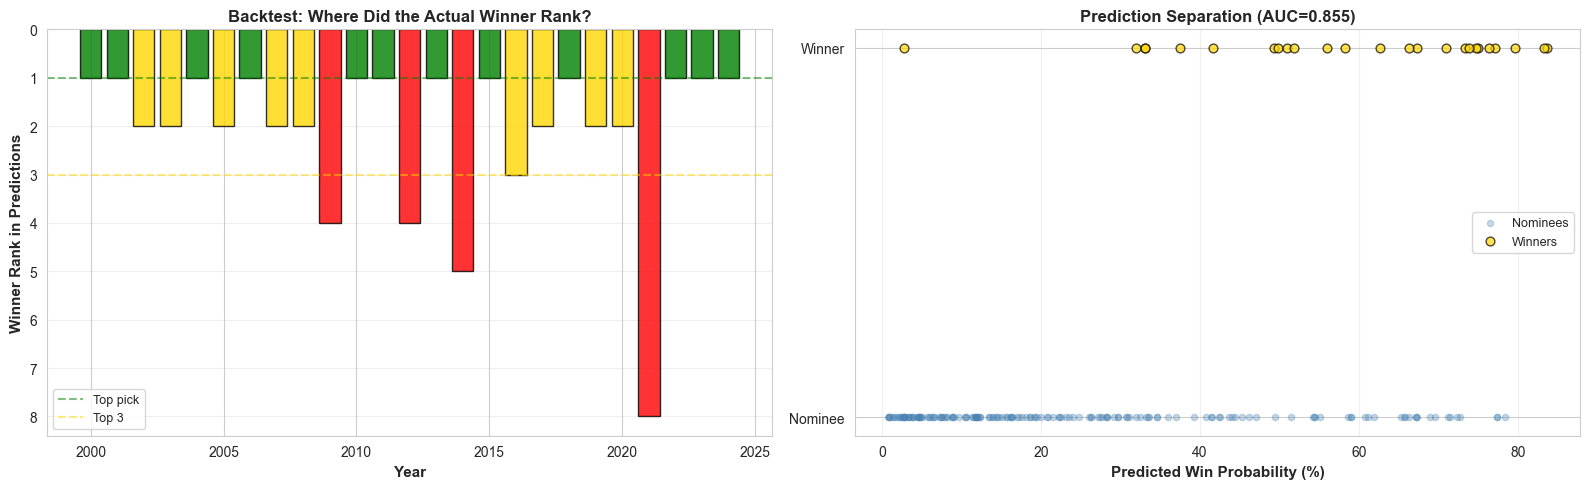

In [90]:
# Detailed Temporal Backtest — using the best configuration from optimization
print("=" * 100)
print(f"TEMPORAL BACKTEST (2000-2024) — {best_config} / {best_model_name}")
print("=" * 100)
print(f"\nFor each year, train on all prior years and predict that year's winner.")
print(f"Using {len(best_features)} features: {best_features}\n")

backtest_start = 2000
backtest_years = sorted([y for y in bp_model[bp_model['year_film'] >= backtest_start]['year_film'].unique()
                         if y < latest_year])

all_probs = []
year_results = []

# Compute GB weight ratio
n_w_bt = bp_model[bp_model['year_film'] < latest_year]['winner'].sum()
n_t_bt = len(bp_model[bp_model['year_film'] < latest_year])
gb_wr_bt = (n_t_bt - n_w_bt) / max(n_w_bt, 1)

for yr in backtest_years:
    bt_train = bp_model[bp_model['year_film'] < yr].copy()
    bt_test = bp_model[bp_model['year_film'] == yr].copy()

    if len(bt_train) < 30 or len(bt_test) == 0:
        continue
    if bt_test['winner'].sum() == 0:
        continue

    bt_scaler = StandardScaler()
    X_bt_train = bt_scaler.fit_transform(bt_train[best_features].values)
    X_bt_test = bt_scaler.transform(bt_test[best_features].values)
    y_bt_train = bt_train['winner'].astype(int).values

    # Train using the best model type
    if best_model_name == 'LR+RF':
        bt_lr = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
        bt_lr.fit(X_bt_train, y_bt_train)
        bt_rf = RandomForestClassifier(
            n_estimators=200, max_depth=10, min_samples_split=5, min_samples_leaf=2,
            class_weight='balanced', random_state=42)
        bt_rf.fit(X_bt_train, y_bt_train)
        avg_p = (bt_lr.predict_proba(X_bt_test)[:, 1] + bt_rf.predict_proba(X_bt_test)[:, 1]) / 2
    elif best_model_name == 'GB':
        bt_gb = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)
        sw_bt = np.where(y_bt_train == 1, gb_wr_bt, 1.0)
        bt_gb.fit(X_bt_train, y_bt_train, sample_weight=sw_bt)
        avg_p = bt_gb.predict_proba(X_bt_test)[:, 1]
    elif best_model_name == 'LR':
        bt_mdl = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
        bt_mdl.fit(X_bt_train, y_bt_train)
        avg_p = bt_mdl.predict_proba(X_bt_test)[:, 1]
    else:  # RF
        bt_mdl = RandomForestClassifier(
            n_estimators=200, max_depth=10, min_samples_split=5, min_samples_leaf=2,
            class_weight='balanced', random_state=42)
        bt_mdl.fit(X_bt_train, y_bt_train)
        avg_p = bt_mdl.predict_proba(X_bt_test)[:, 1]

    bt_test = bt_test.copy()
    bt_test['avg_prob'] = avg_p
    bt_test['y_true'] = bt_test['winner'].astype(int)

    # Did the model's top pick win?
    top_pick = bt_test.sort_values('avg_prob', ascending=False).iloc[0]
    actual_winner = bt_test[bt_test['winner'] == True].iloc[0]['film']
    correct = top_pick['winner']
    winner_rank = bt_test.sort_values('avg_prob', ascending=False).reset_index()
    winner_rank = winner_rank[winner_rank['winner'] == True].index[0] + 1

    year_results.append({
        'year': yr,
        'top_pick': top_pick['film'],
        'actual_winner': actual_winner,
        'correct': correct,
        'winner_rank': winner_rank,
        'winner_prob': bt_test[bt_test['winner'] == True].iloc[0]['avg_prob'],
        'top_prob': top_pick['avg_prob'],
        'n_nominees': len(bt_test),
    })

    for _, r in bt_test.iterrows():
        all_probs.append({'y_true': r['y_true'], 'prob': r['avg_prob'], 'year': yr})

bt_results = pd.DataFrame(year_results)
all_probs_df = pd.DataFrame(all_probs)

# Overall AUC
overall_auc = roc_auc_score(all_probs_df['y_true'], all_probs_df['prob'])

# Print results
print(f"{'Year':<6} {'Top Pick':<40} {'Actual Winner':<40} {'Rank':>4} {'Prob':>6} {'Result'}")
print("-" * 110)
for _, r in bt_results.iterrows():
    mark = "HIT" if r['correct'] else f"#{int(r['winner_rank'])}"
    print(f"{int(r['year']):<6} {r['top_pick'][:38]:<40} {r['actual_winner'][:38]:<40} {int(r['winner_rank']):>4} {r['winner_prob']:>5.1%}  {mark}")

n_correct = bt_results['correct'].sum()
n_total = len(bt_results)
top3 = (bt_results['winner_rank'] <= 3).sum()
avg_rank = bt_results['winner_rank'].mean()

print(f"\n{'='*110}")
print(f"BACKTEST SUMMARY ({backtest_start}-{backtest_years[-1]})")
print(f"{'='*110}")
print(f"  Overall AUC:            {overall_auc:.3f}")
print(f"  Top-1 accuracy:         {n_correct}/{n_total} ({n_correct/n_total*100:.0f}%)")
print(f"  Top-3 accuracy:         {top3}/{n_total} ({top3/n_total*100:.0f}%)")
print(f"  Avg winner rank:        {avg_rank:.1f}")
print(f"  Years backtested:       {n_total}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Winner rank over time
ax = axes[0]
colors_rank = ['green' if r == 1 else 'gold' if r <= 3 else 'red' for r in bt_results['winner_rank']]
ax.bar(bt_results['year'], bt_results['winner_rank'], color=colors_rank, edgecolor='black', alpha=0.8)
ax.axhline(y=1, color='green', linestyle='--', alpha=0.5, label='Top pick')
ax.axhline(y=3, color='gold', linestyle='--', alpha=0.5, label='Top 3')
ax.set_xlabel('Year', fontsize=11, fontweight='bold')
ax.set_ylabel('Winner Rank in Predictions', fontsize=11, fontweight='bold')
ax.set_title('Backtest: Where Did the Actual Winner Rank?', fontsize=12, fontweight='bold')
ax.invert_yaxis()
ax.legend(fontsize=9)
ax.grid(axis='y', alpha=0.3)

# Probability calibration
ax = axes[1]
ax.scatter(all_probs_df[all_probs_df['y_true']==0]['prob'] * 100,
           [0] * (all_probs_df['y_true']==0).sum(),
           alpha=0.3, color='steelblue', label='Nominees', s=20)
ax.scatter(all_probs_df[all_probs_df['y_true']==1]['prob'] * 100,
           [1] * (all_probs_df['y_true']==1).sum(),
           alpha=0.7, color='gold', label='Winners', s=40, edgecolors='black')
ax.set_xlabel('Predicted Win Probability (%)', fontsize=11, fontweight='bold')
ax.set_yticks([0, 1])
ax.set_yticklabels(['Nominee', 'Winner'])
ax.set_title(f'Prediction Separation (AUC={overall_auc:.3f})', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()
print("=" * 100)

## Latest Year Predictions

Hold-out evaluation on the most recent year in the RDF dataset.
When new years are added to the knowledge graph, the notebook automatically picks them up.

BEST PICTURE PREDICTIONS — 2025 HOLD-OUT
Model: E: Above-line focus / LR+RF

Rank  Win %     Film                                                   Actual
------------------------------------------------------------------------------------------
1      78.4%    One Battle After Another                               
2      67.0%    Marty Supreme                                          
3      47.6%    Sentimental Value                                      
4      20.6%    Sinners                                                
5      16.8%    Hamnet                                                 
6       9.5%    F1                                                     
7       5.2%    Frankenstein                                           
8       4.8%    Bugonia                                                
9       2.6%    Train Dreams                                           


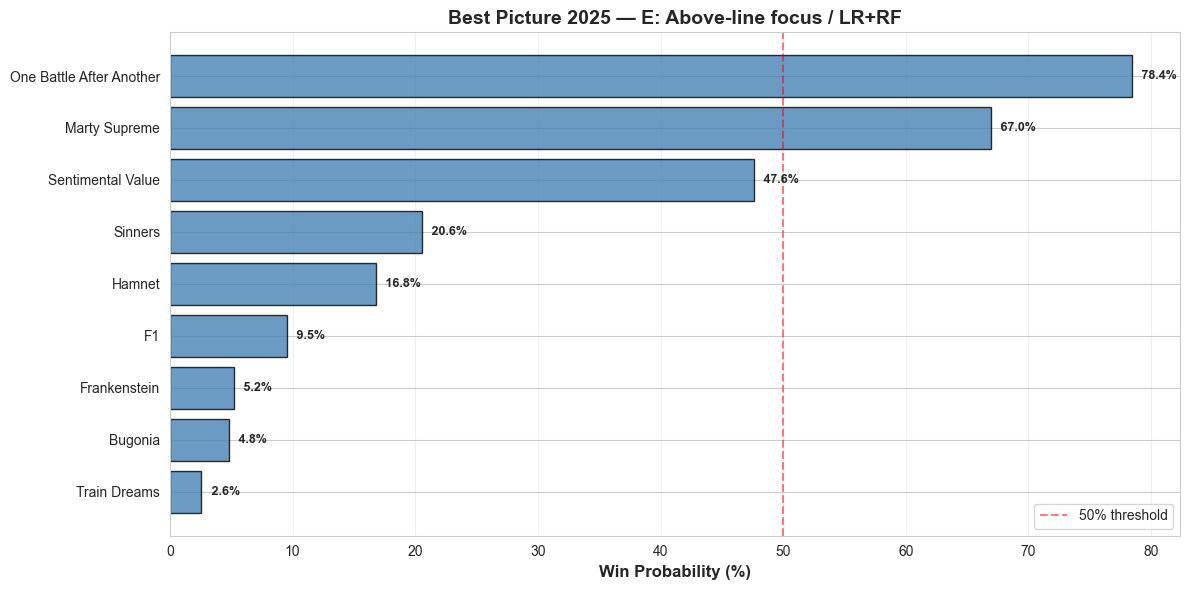


TOP 3 CANDIDATES — KEY FACTORS

1. One Battle After Another (78.4% win probability)
   ----------------------------------------------------------------------
     above_line_noms                    :     5.00  (z=+1.46, above avg 2.97)
     editing_nom                        :     1.00  (z=+0.84, above avg 0.59)
     imdb_rating                        :     7.90  (z=+0.46, above avg 7.68)
     log_revenue                        :    19.14  (z=+0.41, above avg 17.72)
     genre_horror                       :     0.00  (z=-0.12, below avg 0.01)

2. Marty Supreme (67.0% win probability)
   ----------------------------------------------------------------------
     above_line_noms                    :     3.00  (z=+0.02, above avg 2.97)
     editing_nom                        :     1.00  (z=+0.84, above avg 0.59)
     imdb_rating                        :     8.10  (z=+0.88, above avg 7.68)
     log_revenue                        :    18.71  (z=+0.29, above avg 17.72)
     genre_horror    

In [91]:
# Latest-year hold-out predictions — using best model from optimization
print("=" * 100)
print(f"BEST PICTURE PREDICTIONS — {latest_year} HOLD-OUT")
print(f"Model: {best_config} / {best_model_name}")
print("=" * 100)

bp_test = bp_model[bp_model['year_film'] == latest_year].copy()
bp_train = bp_model[bp_model['year_film'] < latest_year].copy()

if len(bp_test) == 0:
    print("\nNo test data available.")
else:
    # Predict using the final best model trained in the optimization cell
    X_test_pred = final_scaler.transform(bp_test[best_features].values)
    bp_test['avg_prob'] = predict_with_best(X_test_pred)

    bp_pred = bp_test.sort_values('avg_prob', ascending=False).copy()

    # Formatted prediction table
    print(f"\n{'Rank':<6}{'Win %':<10}{'Film':<55}{'Actual'}")
    print("-" * 90)
    for i, (_, row) in enumerate(bp_pred.iterrows(), 1):
        actual = "WINNER" if row['winner'] else ""
        print(f"{i:<6}{row['avg_prob']:>6.1%}    {row['film'][:53]:<55}{actual}")

    # Bar chart of win probabilities
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = ['gold' if w else 'steelblue' for w in bp_pred['winner']]
    bars = ax.barh(range(len(bp_pred)), bp_pred['avg_prob'] * 100,
                   color=colors, edgecolor='black', alpha=0.8)
    ax.set_yticks(range(len(bp_pred)))
    ax.set_yticklabels(bp_pred['film'].values, fontsize=10)
    ax.invert_yaxis()
    ax.set_xlabel('Win Probability (%)', fontsize=12, fontweight='bold')
    ax.set_title(f'Best Picture {latest_year} — {best_config} / {best_model_name}',
                 fontsize=14, fontweight='bold')

    for i, (_, row) in enumerate(bp_pred.iterrows()):
        label = f" {row['avg_prob']:.1%}"
        if row['winner']:
            label += " (WINNER)"
        ax.text(row['avg_prob'] * 100 + 0.5, i, label, va='center', fontsize=9, fontweight='bold')

    ax.axvline(x=50, color='red', linestyle='--', alpha=0.5, label='50% threshold')
    ax.legend(fontsize=10)
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Factor breakdown for top 3
    print("\n" + "=" * 100)
    print("TOP 3 CANDIDATES — KEY FACTORS")
    print("=" * 100)

    for i, (_, row) in enumerate(bp_pred.head(3).iterrows(), 1):
        actual_str = " (ACTUAL WINNER)" if row['winner'] else ""
        print(f"\n{i}. {row['film']} ({row['avg_prob']:.1%} win probability){actual_str}")
        print("   " + "-" * 70)
        for feat in best_features:
            value = row[feat]
            feat_mean = bp_train[feat].mean()
            feat_std = bp_train[feat].std()
            direction = "above" if value > feat_mean else "below"
            if feat_std > 0:
                z_score = (value - feat_mean) / feat_std
                print(f"     {feat:35s}: {value:>8.2f}  (z={z_score:+.2f}, {direction} avg {feat_mean:.2f})")
            else:
                print(f"     {feat:35s}: {value:>8.2f}  (avg {feat_mean:.2f})")

    # Save predictions
    out_cols = ['film', 'year_film', 'winner', 'avg_prob'] + best_features
    out_cols = [c for c in out_cols if c in bp_pred.columns]
    out_file = f'predictions_best_picture_{latest_year}.csv'
    bp_pred[out_cols].to_csv(out_file, index=False)
    print(f"\nSaved predictions to {out_file}")

print("\n" + "=" * 100)

BETTING ANALYSIS — 2025 BEST PICTURE
Model: E: Above-line focus / LR+RF

Film                            Market   Model    Edge   EV/$1  Kelly%  Note
-----------------------------------------------------------------------------------------------
Marty Supreme                       4%   67.0%  +63.0%  +15.74    2.6%  
Sentimental Value                   9%   47.6%  +38.6%   +4.29    3.8%  
Sinners                             6%   20.6%  +14.6%   +2.43    0.9%  
Hamnet                              3%   16.8%  +13.8%   +4.61    0.4%  
F1                                  1%    9.5%   +8.5%   +8.54    0.1%  
One Battle After Another           72%   78.4%   +6.4%   +0.09   16.5%  
Frankenstein                        1%    5.2%   +4.2%   +4.20    0.0%  
Bugonia                             1%    4.8%   +3.8%   +3.84    0.0%  
Train Dreams                        2%    2.6%   +0.6%   +0.28    0.0%  
The Secret Agent                    1%    nan%   +nan%    +nan    nan%  no model prediction
Tie  

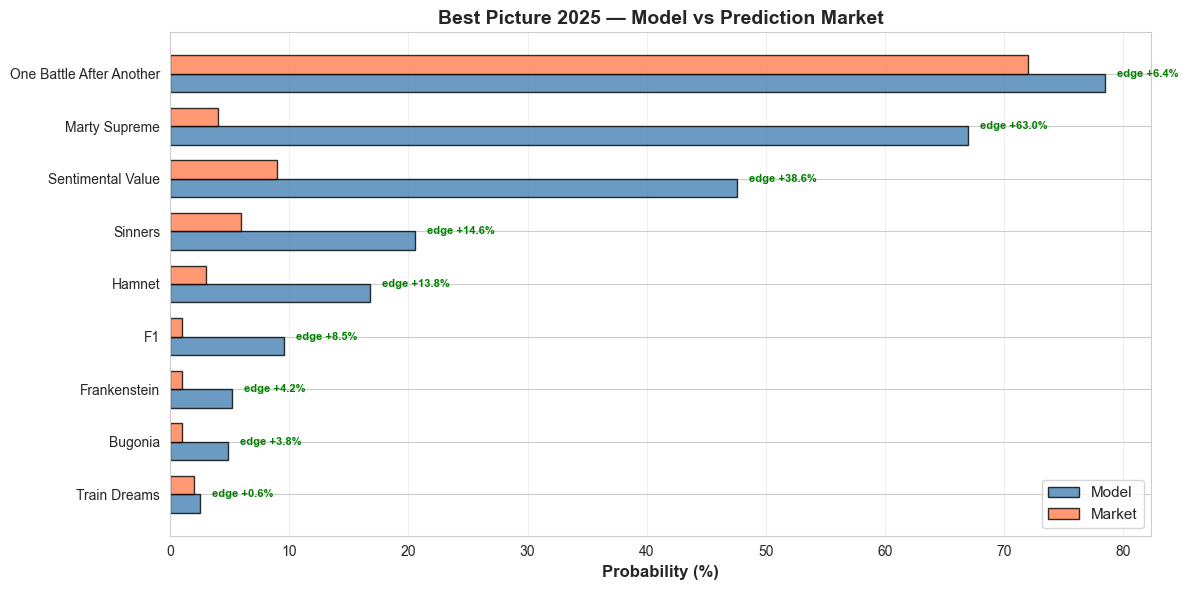

In [92]:
# Betting Analysis — Model vs Prediction Market
print("=" * 100)
print(f"BETTING ANALYSIS — {latest_year} BEST PICTURE")
print(f"Model: {best_config} / {best_model_name}")
print("=" * 100)

# Prediction market odds (price in cents = implied probability in %)
# Source: Polymarket / prediction markets, Feb 2025
market_odds = {
    "One Battle After Another": 72,
    "Sentimental Value":         9,
    "Sinners":                   6,
    "Marty Supreme":             4,
    "Hamnet":                    3,
    "Train Dreams":              2,
    "F1":                        1,
    "Frankenstein":              1,
    "Bugonia":                   1,
    "The Secret Agent":          1,
    "Tie":                       1,
}

# Build comparison table
rows = []
for film, price_cents in market_odds.items():
    implied_prob = price_cents / 100.0
    match = bp_pred[bp_pred['film'] == film]
    if len(match) == 0:
        rows.append({
            'film': film, 'market_prob': implied_prob,
            'model_prob': None, 'edge': None, 'ev_per_dollar': None, 'kelly': None,
            'note': 'no model prediction'
        })
        continue
    model_prob = match['avg_prob'].values[0]
    payout = 1.0 / implied_prob  # payout per $1 risked on a win
    edge = model_prob - implied_prob
    ev = (model_prob * payout) - 1.0  # expected profit per $1
    kelly_raw = edge / (payout - 1.0) if payout > 1 else 0.0
    kelly = max(0.0, min(kelly_raw, 0.20))  # cap at 20%, floor at 0
    rows.append({
        'film': film, 'market_prob': implied_prob, 'model_prob': model_prob,
        'edge': edge, 'ev_per_dollar': ev, 'kelly': kelly, 'note': ''
    })

bet_df = pd.DataFrame(rows)

# --- Comparison table ---
print(f"\n{'Film':<30}{'Market':>8}{'Model':>8}{'Edge':>8}{'EV/$1':>8}{'Kelly%':>8}  {'Note'}")
print("-" * 95)
for _, r in bet_df.sort_values('edge', ascending=False, na_position='last').iterrows():
    mkt = f"{r['market_prob']:.0%}"
    if r['model_prob'] is None:
        print(f"{r['film']:<30}{mkt:>8}{'—':>8}{'—':>8}{'—':>8}{'—':>8}  {r['note']}")
    else:
        mdl = f"{r['model_prob']:.1%}"
        edge = f"{r['edge']:+.1%}"
        ev = f"{r['ev_per_dollar']:+.2f}"
        kelly = f"{r['kelly']:.1%}"
        print(f"{r['film']:<30}{mkt:>8}{mdl:>8}{edge:>8}{ev:>8}{kelly:>8}  {r['note']}")

# --- Positive-EV recommendations ---
pos_ev = bet_df[(bet_df['ev_per_dollar'].notna()) & (bet_df['ev_per_dollar'] > 0)].sort_values('ev_per_dollar', ascending=False)
print("\n" + "=" * 100)
if len(pos_ev) == 0:
    print("NO POSITIVE-EV BETS FOUND — market prices appear efficient vs model.")
else:
    print(f"POSITIVE-EV BETS ({len(pos_ev)} found)")
    print("=" * 100)
    for _, r in pos_ev.iterrows():
        payout = 1.0 / r['market_prob']
        print(f"\n  {r['film']}")
        print(f"    Market: {r['market_prob']:.0%}  |  Model: {r['model_prob']:.1%}  |  Edge: {r['edge']:+.1%}")
        print(f"    EV per $1 bet: {r['ev_per_dollar']:+.2f}  |  Payout: {payout:.1f}x  |  Kelly: {r['kelly']:.1%}")
    total_kelly = pos_ev['kelly'].sum()
    print(f"\n  Total Kelly allocation: {total_kelly:.1%} of bankroll")

# --- Bar chart: model vs market ---
plot_df = bet_df[bet_df['model_prob'].notna()].sort_values('model_prob', ascending=True).copy()
fig, ax = plt.subplots(figsize=(12, 6))
y = np.arange(len(plot_df))
bar_h = 0.35
ax.barh(y - bar_h/2, plot_df['model_prob'] * 100, bar_h, label='Model', color='steelblue', edgecolor='black', alpha=0.8)
ax.barh(y + bar_h/2, plot_df['market_prob'] * 100, bar_h, label='Market', color='coral', edgecolor='black', alpha=0.8)
ax.set_yticks(y)
ax.set_yticklabels(plot_df['film'].values, fontsize=10)
ax.set_xlabel('Probability (%)', fontsize=12, fontweight='bold')
ax.set_title(f'Best Picture {latest_year} — Model vs Prediction Market', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(axis='x', alpha=0.3)

# Annotate edges
for i, (_, r) in enumerate(plot_df.iterrows()):
    edge_val = r['edge']
    color = 'green' if edge_val > 0 else 'red'
    ax.text(max(r['model_prob'], r['market_prob']) * 100 + 1, i,
            f"edge {edge_val:+.1%}", va='center', fontsize=8, fontweight='bold', color=color)

plt.tight_layout()
plt.show()

print("\n" + "=" * 100)